# Embeddings with Time Series Dataset


In [2]:
# @title Query a table with SQL and magic commands
# Running this code will query a table in BigQuery and download
# the results to a Pandas DataFrame named `results`.
# Learn more here: https://cloud.google.com/bigquery/docs/visualize-jupyter

%%bigquery results --project jc-gcp-project
SELECT * FROM `jc-gcp-project.vector_search.liquor_sample` #this example uses a penguin public dataset. Learn more here: https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=penguins&page=table&_ga=2.251359750.1031997792.1692116300-1119797950.1692116300

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
# You can view the resulting Pandas DataFrame and work with using the Pandas library.
# https://pandas.pydata.org/docs/getting_started/index.html#getting-started
results

,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,S12670300049,2013-06-12,3385,ABSOLUT SWEDISH VODKA 80 PRF,30,899.70
1,INV-55995300089,2023-02-20,4829,DR MCGILLICUDDYS MENTHOLMINT,60,990.00
2,S15066900006,2013-10-10,4829,CROWN ROYAL CANADIAN WHISKY,144,3941.28
3,S23078800071,2014-12-20,3592,JOSE CUERVO MANGO MARGARITA,30,369.00
4,INV-04645100062,2017-04-28,3443,MARGARITAVILLE GOLD TEQUILA,60,676.20
...,...,...,...,...,...,...
28389275,INV-12455200017,2018-06-05,5261,BLACK VELVET,48,112.32
28389276,INV-46341800012,2022-04-08,6095,HAWKEYE VODKA,48,83.04
28389277,INV-39987200014,2021-09-11,4602,JIM BEAM APPLE,48,90.24
28389278,INV-54253400010,2022-12-21,5826,SMIRNOFF 80PRF,48,359.52


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pandas_gbq
import datetime

# BigQuery 명령어를 사용하여 Preprocessed Table 만들기

In [ ]:
### Public Data 가져오기
%%bigquery df_preprocessed --project jc-gcp-project
CREATE or REPLACE TABLE vector_search.liquor_preprocessed AS
SELECT
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold
    FROM
        `jc-gcp-project.vector_search.liquor_sample`
    GROUP BY
        date, item_name

Query is running:   0%|          |

In [6]:
%%bigquery df_preprocessed --project jc-gcp-project
SELECT *
FROM `jc-gcp-project.vector_search.liquor_preprocessed`

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
df_preprocessed

,date,item_name,total_amount_sold
0,2022-10-03,GRAND MARNIER W/ ROCKS GLASS GIFT SET,0
1,2020-01-16,TEN HIGH,256
2,2020-03-18,TANQUERAY GIN,256
3,2017-04-27,REMY MARTIN VSOP,256
4,2015-11-11,NEW AMSTERDAM GIN,256
...,...,...,...
3231509,2023-09-25,HA KEEPERS HEART 10YO SINGLE MALT,-1
3231510,2022-10-07,DALWHINNIE 15YR SINGLE MALT SCOTCH,-1
3231511,2023-10-26,WESTWARD CASK STRENGTH 125 WHISKEY,-1
3231512,2023-06-14,SOOH JINRO CHAMISUL GRAPEFRUIT SOJU,-1


# 데이터 분석을 하기위해 전처리 완료한 Table (Test할때 여기부터)

In [8]:
# 확인
df_preprocessed.sort_values('total_amount_sold', ascending = False)

,date,item_name,total_amount_sold
762844,2013-10-04,BLACK VELVET,30306
3119059,2021-11-22,FIREBALL CINNAMON WHISKEY,28973
1527340,2012-10-05,BLACK VELVET,24948
2472478,2013-10-11,BLACK VELVET,24534
343749,2020-09-23,TITOS HANDMADE VODKA,24097
...,...,...,...
1119737,2023-08-21,SOOH 1800 SILVER,-113
2658279,2022-07-29,JUAREZ GOLD DSS,-156
463714,2023-03-21,SOOH JINRO STRAWBERRY SOJU,-200
3034980,2023-01-05,FOUNDRY WHISKEY CUSTOM,-294


In [9]:
# ordey by
df_preprocessed = df_preprocessed.sort_values(by=['item_name','date'], ascending=[True,True])

In [10]:
# 데이터 확인
df_preprocessed.head(10)

,date,item_name,total_amount_sold
1253305,2017-02-23,"""BEEFEATER """"24""""""",6
901216,2017-03-22,"""BEEFEATER """"24""""""",6
1628541,2016-08-29,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",3
1910438,2016-08-31,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",4
460356,2016-09-01,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",2
913905,2016-09-06,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",6
1520608,2016-09-07,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",2
3071373,2016-09-08,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",5
2757095,2016-09-13,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",6
4563,2016-09-15,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",1


### Vector 만들기 위한 전처리

In [13]:
# Set the window size (number of rows in each window)
window_size = 20
step_size = 5

In [14]:
np.unique(df_preprocessed['item_name'])[0:2000]

array(['"BEEFEATER ""24"""', '"JOSE CUERVO SILVER ""ROLLING STONES"""',
       '"RUMCHATA ""GOCHATAS"""', ..., 'BURNETTS LIMEADE VODKA',
       'BURNETTS MANGO', 'BURNETTS MANGO PINEAPPLE'], dtype=object)

In [ ]:
####### Vector용 전처리
windows_tmp = []
embedding_vec = pd.DataFrame()
for i in np.unique(df_preprocessed['item_name'])[0:2000]:
  df_preprc_tmp = df_preprocessed[df_preprocessed['item_name'] == i]
  print('item name: ', i)
  # one item loop
  if len(df_preprc_tmp)>20:
    windows_tmp = [
    df_preprc_tmp.iloc[i : i + window_size]
    # make one vector by window size
    for i in range(0, len(df_preprc_tmp) - window_size + 1, step_size)]
    start_times = [w["date"].iloc[0] for w in windows_tmp]
    end_times = [w["date"].iloc[-1] for w in windows_tmp]
    item_name = [w["item_name"].iloc[0] for w in windows_tmp]
    # item_name_1 = [w["item_name"].iloc[-1] for w in windows_tmp]
    tot_sold = [w["total_amount_sold"].tolist() for w in windows_tmp]
    # Create a new DataFrame from the collected data
    embedding_df = pd.DataFrame({"start_time": start_times, "end_time": end_times,
                                 "item_name":item_name, "vectors": tot_sold})
    # Dataset : embedding_vec
    embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)

item name:  "BEEFEATER ""24"""
item name:  "JOSE CUERVO SILVER ""ROLLING STONES"""


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  "RUMCHATA ""GOCHATAS"""
item name:  "RUMCHATA ""MINICHATAS"" CREAMER CUPS"


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  (RI)1 RYE
item name:  10 CANE RUM


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  100 ANOS ANEJO
item name:  100 ANOS AZUL 100% AGAVE
item name:  10TH MOUNTAIN BOURBON
item name:  10TH MOUNTAIN CORDIAL


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  10TH MOUNTAIN RYE
item name:  135 EAST HYOGO JAPANESE DRY GIN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  135° EAST HYOGO JAPANESE DRY GIN
item name:  135� EAST HYOGO JAPANESE DRY GIN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  173 CRAFT DISTILLERY BARREL & KANE
item name:  173 CRAFT DISTILLERY BOURBON WHISKEY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  173 CRAFT DISTILLERY BROKEN BEAKER RUM
item name:  173 CRAFT DISTILLERY BROKEN BEAKER SILVER RUM
item name:  173 CRAFT DISTILLERY PREMIUM GIN
item name:  173 CRAFT DISTILLERY PREMIUM VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  173 CRAFT DISTILLERY SPICED RUM
item name:  173 CRAFT DISTILLERY VOLUMETRIC GIN
item name:  173 CRAFT DISTILLERY VOLUMETRIC VODKA
item name:  1792 12YR OLD BOURBON
item name:  1792 BOTTLE IN BOND BOURBON
item name:  1792 BOTTLED IN BOND BOURBON


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1792 BOTTLED IN BOND BOURBON BARREL
item name:  1792 CHOCOLATE BOURBON BALL CREAM


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1792 FULL PROOF
item name:  1792 FULL PROOF BUY THE BARREL
item name:  1792 PORT FINISH BOURBON HA
item name:  1792 SINGLE BARREL
item name:  1792 SINGLE BARREL BOURBON
item name:  1792 SINGLE BARREL BUY THE BARREL


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1792 SINGLE BARREL HA
item name:  1792 SMALL BATCH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1792 SMALL BATCH BOURBON


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1792 SWEET WHEAT BOURBON
item name:  1792 SWEET WHEAT HA
item name:  18 CASES SMIRNOFF 1.75L/18 CASES CAPTAIN 1.75L
item name:  1800 ANEJO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ANEJO TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 COCONUT


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 COCONUT MINI
item name:  1800 COCONUT TEQUILA
item name:  1800 CRISTALINO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 CUCUMBER & JALAPENO
item name:  1800 PASSION FRUIT ULTIMATE MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 PEACH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 PEACH MARGARITA
item name:  1800 REPOSADO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 REPOSADO 750ML & 1800 POMEGRANATE MIXER
item name:  1800 REPOSADO TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 REPOSADO TEQUILA WITH CLAY CUP
item name:  1800 REPOSADO W/CLAY CUP


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 REPOSADO W/SERVING BOWLS
item name:  1800 SILVER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 SILVER 750ML W/1800 COCONUT 200ML
item name:  1800 SILVER MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 SILVER TEQUILA
item name:  1800 SILVER TEQUILA 750ML W/ 1800 COCONUT 200ML


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 SILVER TEQUILA W/REPLICA SHOT GLASSES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 SILVER W/1800 COCONUT 50ML & PINEAPPLE JUICE
item name:  1800 SILVER W/2 METAL COASTERS
item name:  1800 SILVER W/FLASK


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 SILVER W/TACO HOLDER
item name:  1800 SILVER/REPOSADO/CRISTALINO VARIETY PACK
item name:  1800 TEQUILA REPOSADO
item name:  1800 ULTIMATE BLACK CHERRY MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE BLACK CHERRY MARGARITA PET
item name:  1800 ULTIMATE BLOOD ORANGE MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE BLOOD ORANGE MARGARITA PET
item name:  1800 ULTIMATE BLUEBERRY RTD
item name:  1800 ULTIMATE JALAPEÑO LIME MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE JALAPE�O
item name:  1800 ULTIMATE JALAPE�O LIME


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE JALAPE�O LIME MARGARITA
item name:  1800 ULTIMATE MANGO MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE MANGO MARGARITA PET


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE MARGARITA
item name:  1800 ULTIMATE MARGARITA PET


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE PEACH MARGARITA
item name:  1800 ULTIMATE PEACH MARGARITA PET


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE PINEAPPLE MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE PINEAPPLE MARGARITA PET
item name:  1800 ULTIMATE PINEAPPLE MARGARITA/RTD
item name:  1800 ULTIMATE POMEGRANATE MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE POMEGRANATE MARGARITA RTD
item name:  1800 ULTIMATE RASPBERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE RASPBERRY MARGARITA
item name:  1800 ULTIMATE RASPBERRY MARGARITA PET


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE SKINNY MARGARITA
item name:  1800 ULTIMATE STRAWBERRY MARGARITA PET


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE WATERMELON MARGARITA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE WATERMELON MARGARITA PET


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1800 ULTIMATE WILD BERRY MARGARITA
item name:  1900 WHISKEY
item name:  1921 ANEJO
item name:  1921 TEQUILA ANEJO
item name:  1921 TEQUILA BLANCO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  1921 TEQUILA CREAM
item name:  1921 TEQUILA REPOSADO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  2 GINGERS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  2 GINGERS MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  2 GINGERS W/2 GLASSES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  21SEEDS CUCUMBER JALAPENO TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  21SEEDS GRAPEFRUIT HIBISCUS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  21SEEDS VALENCIA ORANGE TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  2XO OAK SERIES
item name:  3 AMIGOS RAMONA''S RESERVE
item name:  3 AMIGOS RAMONAS RESERVE
item name:  3 VODKA
item name:  3-OAKS DISTILLERY STRAIGHT BOURBON WHISKEY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  3-OAKS DISTILLERY WHISKEY
item name:  360 BING CHERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 BING CHERRY MINI
item name:  360 BING CHERRY VODKA
item name:  360 BUTTERED POPCORN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 BUTTERED POPCORN MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 CONCORD GRAPE
item name:  360 CONCORD GRAPE VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 CONCORD GRAPE VODKA MINI
item name:  360 DOUBLE CHOCOLATE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 DOUBLE CHOCOLATE VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 DOUBLE CHOCOLATE W/GRAVITY UNIT
item name:  360 GEORGIA PEACH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 GEORGIA PEACH VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 GEORGIA PEACH VODKA MINI
item name:  360 GLAZED DONUT


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 GLAZED DONUT FLAVORED VODKA
item name:  360 GLAZED DONUT MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 GRAPE
item name:  360 GRAPE VODKA
item name:  360 HUCKLEBERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 HUCKLEBERRY FLAVORED VODKA
item name:  360 HUCKLEBERRY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 HUCKLEBERRY VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 KC BARBEQUE VODKA
item name:  360 LIME


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 LIME MINI
item name:  360 LIME VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 LIME VODKA MINI
item name:  360 MADAGASCAR VANILLA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 MADAGASCAR VANILLA VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 MADAGASCAR VANILLA VODKA MINI
item name:  360 MANDARIN ORANGE
item name:  360 MANDARIN ORANGE VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 MANDARIN ORANGE VODKA MINI
item name:  360 MANGO
item name:  360 RED DELICIOUS APPLE
item name:  360 RED DELICIOUS APPLE VODKA
item name:  360 RED RASPBERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 RED RASPBERRY FLAVORED VODKA
item name:  360 RED RASPBERRY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 ROYAL BERRY
item name:  360 SORRENTO LEMON
item name:  360 SORRENTO LEMON FLAVORED VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 SORRENTO LEMON MINI
item name:  360 SORRENTO LEMON VODKA
item name:  360 SORRENTO LEMON VODKA MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 VODKA PATRIOT
item name:  360 VODKA PATRIOT 1.75L W/360 MANGO 50ML


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  360 WATERMELON FLAVORED VODKA
item name:  360 WATERMELON VODKA
item name:  4 COPAS BLANCO USDA ORGANIC AND KOSHER CERTIFIED
item name:  4 COPAS TEQUILA ANEJO - USDA ORGANIC AND KOSHER CERTIFIED
item name:  4 ORANGE VODKA
item name:  400 CONEJOS MEZCAL


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  42 BELOW PURE VODKA
item name:  44 NORTH CHERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  44 NORTH HUCKLEBERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  44 NORTH HUCKLEBERRY VODKA
item name:  44 NORTH MAGIC VALLEY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  44 NORTH POTATO VODKA
item name:  44 NORTH RAINIER CHERRY FLAVORED VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  45TH PARALLEL VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  5 YEAR IRISH SINGLE GRAIN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  77 WHISKEY NEW YORK WHEAT
item name:  8 SECONDS CANADIAN WHISKEY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  801 BOURBON WHISKEY
item name:  818 ANEJO TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  818 BLANCO TEQUILA
item name:  818 REPOSADO TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  901 TEQUILA HA
item name:  99 APPLE WHISKEY MINI
item name:  99 APPLES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 APPLES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 APPLES MINI DISPLAY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BANANAS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BANANAS MINI
item name:  99 BLACKBERRIES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BLACKBERRIES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BLACKBERRIES MINI DISPLAY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BLUE RASPBERRIES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BLUE RASPBERRIES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND ADULT VARIETY TRICK & TREAT BAG


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND ADULT VARIETY TRICK & TREAT BAG MINI
item name:  99 BRAND CANDY CANES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND CHERRY LIMEADE PET MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND COCONUT
item name:  99 BRAND FRUIT PUNCH PET MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND GUAVA MINI
item name:  99 BRAND MYSTERY FLAVOR PET MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND PEANUT BUTTER WHISKEY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BRAND VARIETY PARTY YARD PACK MINI
item name:  99 BUTTERSCOTCH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 BUTTERSCOTCH MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 CHERRIES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 CHERRIES - USE CODE 994154
item name:  99 CHERRIES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 CHERRIES MINI - USE CODE 994155
item name:  99 CHOCOLATE MINI
item name:  99 CINNAMON


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 CINNAMON MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 COCONUT MINI
item name:  99 FAMILY 4-50MLS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 FRUITS 10PK


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 FRUITS MINI
item name:  99 GOLD TEQUILA MINI
item name:  99 GRAPE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 GRAPES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 GRAPES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 GRAPES PET MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 HOLIDAY ORNAMENT MINIS
item name:  99 LEMON LIME


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 LEMON LIME MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 LONG ISLAND ICED TEA MINI
item name:  99 MANGOES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 MANGOES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 ORANGES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 ORANGES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PARTY BUCKET MINIS
item name:  99 PASSION FRUIT MINI
item name:  99 PEACH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PEACH BRANDY MINI
item name:  99 PEACHES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PEACHES MINI
item name:  99 PEACHES PET MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PEANUT BUTTER WHISKEY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PEPPERMINT


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PEPPERMINT MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PICKLE MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PINEAPPLE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PINEAPPLE MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PINK LEMONADE
item name:  99 PINK LEMONADE MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 PUNCHES VARIETY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 RAINBOW PACK MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 RASPBERRY MINI
item name:  99 RASPBERRY VODKA MINI
item name:  99 RED MINI
item name:  99 ROOT BEER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 ROOT BEER MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 ROOTBEER
item name:  99 ROOTBEER MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 SALTED CARAMEL MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 SOUR APPLE MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 SOUR BERRY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 SOUR CHERRY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 STRAWBERRIES MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 VODKA MINI
item name:  99 WATERMELON
item name:  99 WATERMELON MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 WATERMELON PET MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 WATERMELON SCHNAPPS
item name:  99 WHIPPED
item name:  99 WHIPPED CREAM


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 WHIPPED CREAM MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 WHIPPED MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 WHISKEY MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  99 XXPRESSO MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  A+


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  A+ LYCHEE & GOJI BERRY
item name:  A+ LYCHEE & GOJI BERRY VODKA
item name:  A+ VODKA
item name:  AALBORG AKVAVIT DANISH LIQUEUR - DNO
item name:  AALBORG JUBILAEUMS AQUAVIT


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  AALBORG TAFFEL AQUAVIT
item name:  ABASOLO ANCESTRAL CORN WHISKY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERFELDY 12 YEAR SINGLE MALT SCOTCH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERFELDY 12YR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERFELDY 16YR W/2 GLASSES & ICE MOLD
item name:  ABERFELDY 21 YEAR SINGLE MALT SCOTCH
item name:  ABERFELDY DISCOVERY PACK
item name:  ABERLOUR 12 YEAR SINGLE MALT SCOTCH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERLOUR 12YR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERLOUR 16YR
item name:  ABERLOUR 16YR SCOTCH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERLOUR 18YR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERLOUR A''BUNADH
item name:  ABERLOUR A'BUNADH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABERLOUR A'BUNADH - USE CODE 994046
item name:  ABERLOUR A'BUNADH 10 YEAR
item name:  ABERLOUR A'BUNADH 10YR
item name:  ABERLOUR ABUNADH ALBA
item name:  ABERLOUR CLASSIC CASK
item name:  ABSENTE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSENTE ABSINTHE REFINED W/2 GLASSES
item name:  ABSENTE W/GLASS & SPOON


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSENTE W/GLASS & SPOON PACK


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSINTHE BLANCO
item name:  ABSINTHE VERDE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT 1.75L W/POWELL & MAHONEY GINGER BEER
item name:  ABSOLUT 750ML WITH 2 JUICE MINI�S
item name:  ABSOLUT 80PRF W/50ML ABSOLUT LIME


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT APEACH


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT BERRI ACAI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT BLACK 100
item name:  ABSOLUT BLUE W/ CLG MINIS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT BLUE W/ CRANBERRY JUICE
item name:  ABSOLUT BLUE W/ALUMINUM TUMBLER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT BLUE W/CRANBERRY JUICE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CHERRYKRAN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CHERRYKRAN MINI
item name:  ABSOLUT CHICAGO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CILANTRO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CILANTRO MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CITRON


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CITRON (LEMON VODKA)


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CITRON MINI
item name:  ABSOLUT CITRON W/ FEVER TREE GINGER BEER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT CITRON W/CRANBERRY JUICE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT COLORS
item name:  ABSOLUT ELECTRIK


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT ELECTRIK W/2 GLASSES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT ELYX


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT GRAPEFRUIT


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT GRAPEFRUIT MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT GRAPEVINE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT GRAPEVINE DISCO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT GRAPEVINE MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT HIBISKUS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT HIBISKUS MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT JUICE EDITION APPLE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT JUICE EDITION STRAWBERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT JUICE PEAR AND ELDERFLOWER EDITION
item name:  ABSOLUT KURANT


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT LIME


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT LIME MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT MANDARIN VODKA
item name:  ABSOLUT MANDRIN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT MANGO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT MANGO VODKA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT MIAMI
item name:  ABSOLUT MINI BAR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT MINI TRIAL PACK


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT NIGHTLIFE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT ORIENT APPLE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT PEARS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT PEPPAR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT RASPBERRI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT RASPBERRI MINI
item name:  ABSOLUT RUBY RED


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT RUBY RED W/ GRAPEFRUIT JUICE
item name:  ABSOLUT SWEDISH VODKA 80 PRF


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT SWEDISH VODKA 80 PRF MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT SWEDISH VODKA 80PRF


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT SWEDISH VODKA 80PRF MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT TEXAS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT TUNE


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT UNIQUE
item name:  ABSOLUT UNITY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT VANILIA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT VODKA 100 PREMIUM


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT VODKA GLIMMER
item name:  ABSOLUT W/ P&M GINGER BEER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/ RISE COLD BREW
item name:  ABSOLUT W/ ZING ZANG BLOODY MARY MIX
item name:  ABSOLUT W/2 CITRON 50ML & 2 MANDRIN 50ML


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/2 GLASSES


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/2-50MLS JUICE MINIS
item name:  ABSOLUT W/4-50MLS


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/50ML CITRON & MANDRIN


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/CRANBERRY JUICE
item name:  ABSOLUT W/FEVER TREE GINGER BEER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/GINGER BEER
item name:  ABSOLUT W/POWELL & MAHONEY BLOODY MARY MIX


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT W/RISE COLD BREW


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT WARHOL


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT WATERMELON


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT WILD BERRI MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT WILD BERRY


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT WILD TEA
item name:  ABSOLUT WITH GINGER BEER


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ABSOLUT ZING ZANG BLOODY MARY MIX
item name:  ACHAIA CLAUSS OUZO GREEK LIQUEUR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ADELAIDES CARAMEL MOCHA MOJO


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ADELAIDES CARAMEL MOCHA MOJO MINI
item name:  ADELAIDES COCONUT LIQUEUR


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ADELAIDES COCONUT LIQUEUR MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ADELAIDES DREAMSICLE MINT CHOCOLATE CHIP
item name:  ADELAIDES DREAMSICLE MINT CHOCOLATE CHIP MINI


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)
<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


item name:  ADICTIVO ANEJO BLACK
item name:  ADICTIVO ANEJO BLACK TEQUILA


<ipython-input-11-77eeee592889>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  embedding_vec = embedding_vec.append(embedding_df, ignore_index=True)


In [ ]:
embedding_vec

,start_time,end_time,item_name,vectors
0,2016-08-29,2016-10-11,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[3, 4, 2, 6, 2, 5, 6, 1, 12, 3, 3, 3, 12, 3, 1..."
1,2016-09-08,2016-10-18,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[5, 6, 1, 12, 3, 3, 3, 12, 3, 15, 12, 36, 27, ..."
2,2016-09-21,2016-10-27,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[3, 3, 12, 3, 15, 12, 36, 27, 1, 2, 14, 14, 12..."
3,2016-09-30,2016-11-14,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[12, 36, 27, 1, 2, 14, 14, 12, 12, 13, 24, 12,..."
4,2016-10-12,2016-11-29,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[14, 14, 12, 12, 13, 24, 12, 12, 12, 2, 14, 1,..."
...,...,...,...,...
100428,2023-11-11,2023-12-15,BURNETTS MANGO PINEAPPLE,"[10, 12, 38, 24, 15, 12, 48, 18, 2, 12, 2, 3, ..."
100429,2023-11-22,2023-12-27,BURNETTS MANGO PINEAPPLE,"[12, 48, 18, 2, 12, 2, 3, 18, 27, 1, 4, 38, 2,..."
100430,2023-12-03,2024-01-07,BURNETTS MANGO PINEAPPLE,"[2, 3, 18, 27, 1, 4, 38, 2, 24, 4, 2, 12, 10, ..."
100431,2023-12-10,2024-01-15,BURNETTS MANGO PINEAPPLE,"[4, 38, 2, 24, 4, 2, 12, 10, 7, 4, 12, 3, 12, ..."


In [ ]:
# Bigquery Insert용으로 다시 전처리
embedding_vec[[i+1 for i in range(window_size)]] = pd.DataFrame(embedding_vec['vectors'].tolist())

In [ ]:
# 전처리 완성본
embedding_vec

,start_time,end_time,item_name,vectors,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
0,2016-08-29,2016-10-11,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[3, 4, 2, 6, 2, 5, 6, 1, 12, 3, 3, 3, 12, 3, 1...",3,4,2,6,2,5,...,3,3,12,3,15,12,36,27,1,2
1,2016-09-08,2016-10-18,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[5, 6, 1, 12, 3, 3, 3, 12, 3, 15, 12, 36, 27, ...",5,6,1,12,3,3,...,12,36,27,1,2,14,14,12,12,13
2,2016-09-21,2016-10-27,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[3, 3, 12, 3, 15, 12, 36, 27, 1, 2, 14, 14, 12...",3,3,12,3,15,12,...,14,14,12,12,13,24,12,12,12,2
3,2016-09-30,2016-11-14,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[12, 36, 27, 1, 2, 14, 14, 12, 12, 13, 24, 12,...",12,36,27,1,2,14,...,24,12,12,12,2,14,1,1,14,7
4,2016-10-12,2016-11-29,"""JOSE CUERVO SILVER """"ROLLING STONES""""""","[14, 14, 12, 12, 13, 24, 12, 12, 12, 2, 14, 1,...",14,14,12,12,13,24,...,14,1,1,14,7,12,1,24,37,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100428,2023-11-11,2023-12-15,BURNETTS MANGO PINEAPPLE,"[10, 12, 38, 24, 15, 12, 48, 18, 2, 12, 2, 3, ...",10,12,38,24,15,12,...,2,3,18,27,1,4,38,2,24,4
100429,2023-11-22,2023-12-27,BURNETTS MANGO PINEAPPLE,"[12, 48, 18, 2, 12, 2, 3, 18, 27, 1, 4, 38, 2,...",12,48,18,2,12,2,...,4,38,2,24,4,2,12,10,7,4
100430,2023-12-03,2024-01-07,BURNETTS MANGO PINEAPPLE,"[2, 3, 18, 27, 1, 4, 38, 2, 24, 4, 2, 12, 10, ...",2,3,18,27,1,4,...,2,12,10,7,4,12,3,12,10,3
100431,2023-12-10,2024-01-15,BURNETTS MANGO PINEAPPLE,"[4, 38, 2, 24, 4, 2, 12, 10, 7, 4, 12, 3, 12, ...",4,38,2,24,4,2,...,12,3,12,10,3,30,4,12,4,3


In [ ]:
# vector컬럼 drop!
embed_save = embedding_vec.drop('vectors', axis=1)

# Type to FLOAT

In [ ]:
# Auto Schema 활용하기 위한 전처리
embed_save[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] = embed_save[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]].astype(float)

In [ ]:
# Bigquery Insert용 확인
embed_save

,start_time,end_time,item_name,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,2016-08-29,2016-10-11,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",3.0,4.0,2.0,6.0,2.0,5.0,6.0,...,3.0,3.0,12.0,3.0,15.0,12.0,36.0,27.0,1.0,2.0
1,2016-09-08,2016-10-18,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",5.0,6.0,1.0,12.0,3.0,3.0,3.0,...,12.0,36.0,27.0,1.0,2.0,14.0,14.0,12.0,12.0,13.0
2,2016-09-21,2016-10-27,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",3.0,3.0,12.0,3.0,15.0,12.0,36.0,...,14.0,14.0,12.0,12.0,13.0,24.0,12.0,12.0,12.0,2.0
3,2016-09-30,2016-11-14,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",12.0,36.0,27.0,1.0,2.0,14.0,14.0,...,24.0,12.0,12.0,12.0,2.0,14.0,1.0,1.0,14.0,7.0
4,2016-10-12,2016-11-29,"""JOSE CUERVO SILVER """"ROLLING STONES""""""",14.0,14.0,12.0,12.0,13.0,24.0,12.0,...,14.0,1.0,1.0,14.0,7.0,12.0,1.0,24.0,37.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100428,2023-11-11,2023-12-15,BURNETTS MANGO PINEAPPLE,10.0,12.0,38.0,24.0,15.0,12.0,48.0,...,2.0,3.0,18.0,27.0,1.0,4.0,38.0,2.0,24.0,4.0
100429,2023-11-22,2023-12-27,BURNETTS MANGO PINEAPPLE,12.0,48.0,18.0,2.0,12.0,2.0,3.0,...,4.0,38.0,2.0,24.0,4.0,2.0,12.0,10.0,7.0,4.0
100430,2023-12-03,2024-01-07,BURNETTS MANGO PINEAPPLE,2.0,3.0,18.0,27.0,1.0,4.0,38.0,...,2.0,12.0,10.0,7.0,4.0,12.0,3.0,12.0,10.0,3.0
100431,2023-12-10,2024-01-15,BURNETTS MANGO PINEAPPLE,4.0,38.0,2.0,24.0,4.0,2.0,12.0,...,12.0,3.0,12.0,10.0,3.0,30.0,4.0,12.0,4.0,3.0


In [ ]:
# 이게 안먹힘 (빅쿼리에 직접 쏘기 X - 스키마 문제...)
# pandas_gbq.to_gbq(embed_save, 'vector_search.embeddings', project_id='jc-gcp-project', if_exists='replace')

In [ ]:
# CSV로 GCS 저장
embed_save.to_csv('gs://jc-gcp-project-01/embed_save.csv')

In [ ]:
# 이것도 안먹힘 (빅쿼리에 직접 쏘기 X - 스키마 문제...)
# pandas_gbq.to_gbq(embed_save, 'vector_search.embeddings', project_id='jc-gcp-project', if_exists='replace',
#                   table_schema = [{'name':'start_time','type': 'DATE'}, {'name':'end_time','type': 'DATE'},
#                    {'name':'item_name','type': 'STRING'}, {'name':1,'type': 'INT'}
#                                   , {'name':2,'type': 'INT'}
#                                   , {'name':3,'type': 'INT'}
#                                   , {'name':4,'type': 'INT'}
#                                   , {'name':5,'type': 'INT'}
#                                   , {'name':6,'type': 'INT'}
#                                   , {'name':7,'type': 'INT'}
#                                   , {'name':8,'type': 'INT'}
#                                   , {'name':9,'type': 'INT'}
#                                   , {'name':10,'type': 'INT'}
#                                   , {'name':11,'type': 'INT'}
#                                   , {'name':12,'type': 'INT'}
#                                   , {'name':13,'type': 'INT'}
#                                   , {'name':14,'type': 'INT'}
#                                   , {'name':15,'type': 'INT'}
#                                   , {'name':16,'type': 'INT'}
#                                   , {'name':17,'type': 'INT'}
#                                   , {'name':18,'type': 'INT'}
#                                   , {'name':19,'type': 'INT'}
#                                   , {'name':20,'type': 'INT'}])

/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py:267: UserWarning: Unable to determine type for field '1'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))
/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py:267: UserWarning: Unable to determine type for field '2'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))
/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py:267: UserWarning: Unable to determine type for field '3'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))
/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py:267: UserWarning: Unable to determine type for field '4'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))
/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py:267: UserWarning: Unable to determi

TypeError: expected bytes, int found

# Manual로 빅쿼리에 테이블 만들기(GCS --> BQ)

# Vector 만들기

In [ ]:
# # Unnested Table
# %%bigquery
# CREATE or REPLACE TABLE vector_search.embed_unnest AS
# SELECT
#   start_time, end_time, item_name,
#   ARRAY_AGG(value) AS unnested_values
# FROM `vector_search.embedding_save`,
# UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
# GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery res
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.embedding_save`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

Downloading:   0%|          |

# Test set 확인

In [ ]:
res

,start_time,end_time,item_name,unnested_values
0,2021-10-08,2021-11-05,1800 REPOSADO,"[51.0, 29.0, 610.0, 86.0, 84.0, 12.0, 29.0, 33..."
1,2023-06-05,2023-06-30,1800 REPOSADO,"[29.0, 98.0, 114.0, 35.0, 60.0, 15.0, 22.0, 50..."
2,2017-09-08,2017-10-05,1800 REPOSADO TEQUILA,"[9.0, 43.0, 20.0, 19.0, 42.0, 20.0, 38.0, 14.0..."
3,2021-05-25,2021-06-17,1800 SILVER,"[154.0, 84.0, 66.0, 156.0, 117.0, 156.0, 224.0..."
4,2022-02-28,2022-03-24,1800 SILVER,"[37.0, 33.0, 83.0, 56.0, 53.0, 113.0, 166.0, 1..."
...,...,...,...,...
100428,2016-03-07,2016-04-07,ARROW PEPPERMINT SCHNAPPS MINI,"[55.0, 26.0, 33.0, 40.0, 41.0, 31.0, 16.0, 25...."
100429,2023-09-13,2023-10-10,ARROW PEPPERMINT SCHNAPPS MINI,"[41.0, 4.0, 6.0, 16.0, 13.0, 3.0, 13.0, 30.0, ..."
100430,2015-08-19,2015-09-22,ARROW PEPPERMINT SCHNAPPS MINI,"[3.0, 36.0, 39.0, 12.0, 39.0, 11.0, 59.0, 19.0..."
100431,2012-08-27,2012-09-27,ARROW PEPPERMINT SCHNAPPS MINI,"[13.0, 38.0, 4.0, 15.0, 15.0, 17.0, 3.0, 25.0,..."


In [ ]:
ABSOLUT APEACH 18014 17972
BIG MACHINE DOUBLE SPIKED CITRUS PEACH  72533 72534 72535
BLACK VELVET 78157 78076

In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_train AS
SELECT * FROM `vector_search.embedding_save` # 여기가 잘 못 됨
WHERE NOT int64_field_0 IN (17972, 18014, 72533, 72534, 72535, 78157, 78076);

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.embed_unnest AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_train`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


# test set 빼놓기

In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test1 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 17972;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test1 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test1`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test2 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 18014;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test2 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test2`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test3 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 72533;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test3 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test3`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test4 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 72534;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test4 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test4`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test5 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 72535;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test5 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test5`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test6 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 78157;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test6 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test6`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


In [ ]:
%%bigquery
CREATE TABLE vector_search.liquor_test7 AS
SELECT * FROM `vector_search.embedding_save`
WHERE int64_field_0  = 78076;

Query is running:   0%|          |

""


In [ ]:
# Unnested Table
%%bigquery
CREATE or REPLACE TABLE vector_search.unnest_test7 AS
SELECT
  start_time, end_time, item_name,
  ARRAY_AGG(value) AS unnested_values
FROM `vector_search.liquor_test7`,
UNNEST([_1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20]) AS value
GROUP BY start_time, end_time, item_name;

Query is running:   0%|          |

""


# Vector Index

In [ ]:
# Create VECTOR_INDEX
%%bigquery
CREATE OR REPLACE VECTOR INDEX embed_idx ON vector_search.embed_unnest(unnested_values)
OPTIONS(distance_type='COSINE', index_type='IVF');

Query is running:   0%|          |

""


In [ ]:
%%bigquery
SELECT *
FROM
  VECTOR_SEARCH(
    TABLE vector_search.embed_unnest,
    'unnested_values',
    TABLE vector_search.unnest_test7,
    top_k => 3,
    distance_type => 'COSINE',
    options => '{"fraction_lists_to_search": 0.005}');

Query is running:   0%|          |

Downloading:   0%|          |

,query,base,distance
0,"{'start_time': 2021-05-10, 'end_time': 2021-05...","{'start_time': 2021-08-18, 'end_time': 2021-09...",0.066431
1,"{'start_time': 2021-05-10, 'end_time': 2021-05...","{'start_time': 2015-03-09, 'end_time': 2015-04...",0.074213
2,"{'start_time': 2021-05-10, 'end_time': 2021-05...","{'start_time': 2017-06-01, 'end_time': 2017-07...",0.075254


In [ ]:
%%bigquery viz_res
SELECT *
FROM
  VECTOR_SEARCH(
    TABLE vector_search.embed_unnest,
    'unnested_values',
    TABLE vector_search.unnest_test1,
    top_k => 5,
    distance_type => 'COSINE',
    options => '{"fraction_lists_to_search": 0.005}');

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
viz_res

,query,base,distance
0,"{'start_time': 2017-05-16 00:00:00, 'end_time'...","{'start_time': 2021-05-06 00:00:00, 'end_time'...",0.056140
1,"{'start_time': 2017-05-16 00:00:00, 'end_time'...","{'start_time': 2023-06-03 00:00:00, 'end_time'...",0.066215
2,"{'start_time': 2017-05-16 00:00:00, 'end_time'...","{'start_time': 2022-11-23 00:00:00, 'end_time'...",0.067741
3,"{'start_time': 2017-05-16 00:00:00, 'end_time'...","{'start_time': 2019-02-07 00:00:00, 'end_time'...",0.071255
4,"{'start_time': 2017-05-16 00:00:00, 'end_time'...","{'start_time': 2015-07-16 00:00:00, 'end_time'...",0.089572


In [ ]:
viz_res.iloc[0]['query']

{'start_time': datetime.datetime(2017, 5, 16, 0, 0),
 'end_time': datetime.datetime(2017, 6, 13, 0, 0),
 'item_name': 'ABSOLUT APEACH',
 'unnested_values': array([59., 16., 40.,  5., 30.,  7., 41., 62., 44., 25., 21., 19.,  5.,
        39.,  9., 37., 71., 17., 26., 35.])}

In [ ]:
viz_res.iloc[0]['base']

{'start_time': datetime.datetime(2021, 5, 6, 0, 0),
 'end_time': datetime.datetime(2021, 6, 2, 0, 0),
 'item_name': 'ABSOLUT APEACH',
 'unnested_values': array([47., 11., 13., 20., 29., 20., 34., 54., 19., 25., 19.,  6.,  2.,
        33., 17., 40., 67., 26.,  6., 43.])}

In [ ]:
viz_res.iloc[2]['base']

{'start_time': datetime.datetime(2022, 11, 23, 0, 0),
 'end_time': datetime.datetime(2022, 12, 29, 0, 0),
 'item_name': 'BACARDI BLACK',
 'unnested_values': array([30.,  2., 14.,  8., 12., 17., 26., 34., 11.,  3.,  6., 12.,  6.,
        30.,  6., 18., 42., 12., 16., 38.])}

#### Slide용 이미지

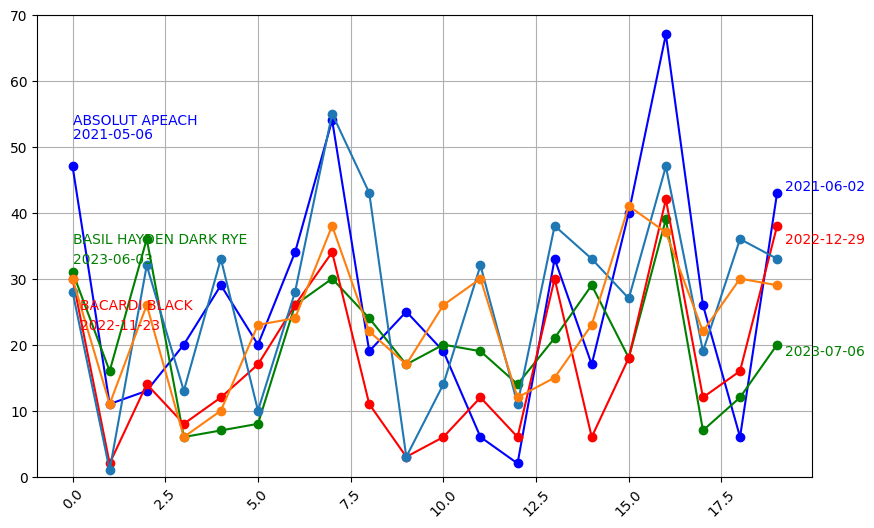

In [ ]:
# Visualise the example pattern
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(20)], viz_res.iloc[0]['base']['unnested_values'], marker="o", linestyle="-", color='b')
plt.text(.01, 55, viz_res.iloc[0].base['item_name'], ha='left', va='top', color='b')
plt.text(.01, 53, viz_res.iloc[0].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')
plt.text(19.2, 45, viz_res.iloc[0].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')

plt.plot([i for i in range(20)], viz_res.iloc[1]['base']['unnested_values'], marker="o", linestyle="-", color='green')
plt.text(.01, 37, viz_res.iloc[1].base['item_name'], ha='left', va='top', color='green')
plt.text(.01, 34, viz_res.iloc[1].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='green')
plt.text(19.2, 20, viz_res.iloc[1].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='green')

plt.plot([i for i in range(20)], viz_res.iloc[2]['base']['unnested_values'], marker="o", linestyle="-", color='r')
plt.text(.2, 27, viz_res.iloc[2].base['item_name'], ha='left', va='top', color='r')
plt.text(.2, 24, viz_res.iloc[2].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='r')
plt.text(19.2, 37, viz_res.iloc[2].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='r')

plt.plot([i for i in range(20)], viz_res.iloc[3]['base']['unnested_values'], marker="o", linestyle="-")
plt.plot([i for i in range(20)], viz_res.iloc[4]['base']['unnested_values'], marker="o", linestyle="-")

# plt.xlabel("Timestamp")
# plt.ylabel("Value")
# plt.title("Query Pattern")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.ylim((0,70))
plt.show()

#### Slide용 이미지

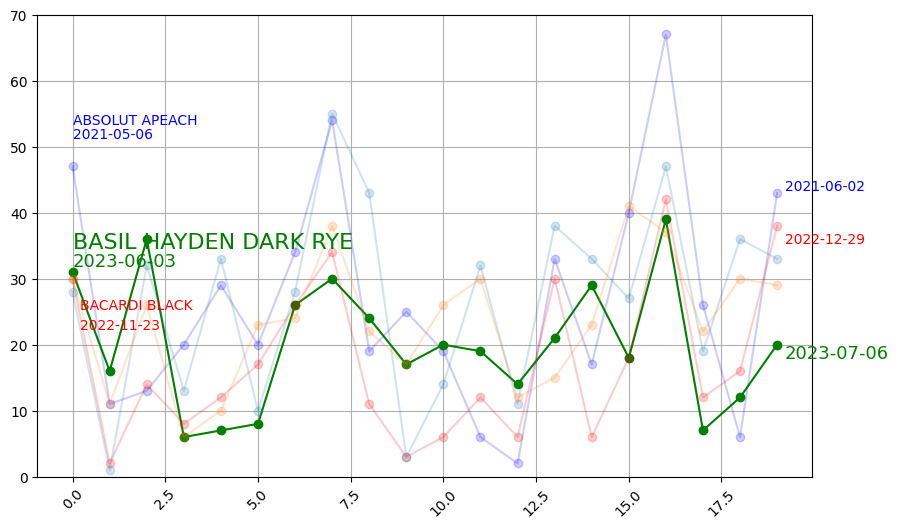

In [ ]:
# Visualise the example pattern
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(20)], viz_res.iloc[0]['base']['unnested_values'], marker="o", linestyle="-", color='b', alpha=0.2)
plt.text(.01, 55, viz_res.iloc[0].base['item_name'], ha='left', va='top', color='b')
plt.text(.01, 53, viz_res.iloc[0].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')
plt.text(19.2, 45, viz_res.iloc[0].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')

plt.plot([i for i in range(20)], viz_res.iloc[1]['base']['unnested_values'], marker="o", linestyle="-", color='green')
plt.text(.01, 37, viz_res.iloc[1].base['item_name'], ha='left', va='top', color='green', fontsize = 16)
plt.text(.01, 34, viz_res.iloc[1].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='green', fontsize = 13)
plt.text(19.2, 20, viz_res.iloc[1].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='green', fontsize = 13)

plt.plot([i for i in range(20)], viz_res.iloc[2]['base']['unnested_values'], marker="o", linestyle="-", color='r', alpha=0.2)
plt.text(.2, 27, viz_res.iloc[2].base['item_name'], ha='left', va='top', color='r')
plt.text(.2, 24, viz_res.iloc[2].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='r')
plt.text(19.2, 37, viz_res.iloc[2].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='r')

plt.plot([i for i in range(20)], viz_res.iloc[3]['base']['unnested_values'], marker="o", linestyle="-", alpha=0.2)
plt.plot([i for i in range(20)], viz_res.iloc[4]['base']['unnested_values'], marker="o", linestyle="-", alpha=0.2)

# plt.xlabel("Timestamp")
# plt.ylabel("Value")
# plt.title("Query Pattern")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.ylim((0,70))
plt.show()

In [ ]:
viz_res.iloc[1].base

{'start_time': datetime.datetime(2023, 6, 3, 0, 0),
 'end_time': datetime.datetime(2023, 7, 6, 0, 0),
 'item_name': 'BASIL HAYDEN DARK RYE',
 'unnested_values': array([31., 16., 36.,  6.,  7.,  8., 26., 30., 24., 17., 20., 19., 14.,
        21., 29., 18., 39.,  7., 12., 20.])}

In [ ]:
df_preprocessed.head()

,date,item_name,total_amount_sold
0,2022-09-20,KESSLER BLEND WHISKEY MINI,0
1,2022-09-29,BIRD DOG PEACH FLAVORED WHISKEY W/ 2 MINIS,0
2,2022-03-31,TANQUERAY GIN,256
3,2021-12-09,DEEP EDDY LEMON,256
4,2012-12-28,RICACHA HORCHATA,256


## BASIL HAYDEN 데이터만 가지고 (6/3 ~ 7/6 까지) demand forecasting진행

In [ ]:
target_df = df_preprocessed[df_preprocessed['item_name'] == 'BASIL HAYDEN DARK RYE'].sort_values('date', ascending = True).reset_index(drop = True)

In [ ]:
target_df

,date,item_name,total_amount_sold
0,2018-11-07,BASIL HAYDEN DARK RYE,46
1,2018-11-08,BASIL HAYDEN DARK RYE,24
2,2018-11-09,BASIL HAYDEN DARK RYE,2
3,2018-11-12,BASIL HAYDEN DARK RYE,11
4,2018-11-13,BASIL HAYDEN DARK RYE,21
...,...,...,...
1149,2024-01-25,BASIL HAYDEN DARK RYE,19
1150,2024-01-26,BASIL HAYDEN DARK RYE,6
1151,2024-01-28,BASIL HAYDEN DARK RYE,6
1152,2024-01-30,BASIL HAYDEN DARK RYE,6


In [ ]:
target_df_1 = target_df[target_df['date'] < datetime.date(2023, 7, 7)]
target_df_1 = target_df[target_df['date'] > datetime.date(2021, 7, 6)]

In [ ]:
len(target_df_1)

622

In [ ]:
target_df_1

,date,item_name,total_amount_sold
532,2021-07-07,BASIL HAYDEN DARK RYE,20
533,2021-07-08,BASIL HAYDEN DARK RYE,2
534,2021-07-09,BASIL HAYDEN DARK RYE,11
535,2021-07-12,BASIL HAYDEN DARK RYE,27
536,2021-07-13,BASIL HAYDEN DARK RYE,12
...,...,...,...
1149,2024-01-25,BASIL HAYDEN DARK RYE,19
1150,2024-01-26,BASIL HAYDEN DARK RYE,6
1151,2024-01-28,BASIL HAYDEN DARK RYE,6
1152,2024-01-30,BASIL HAYDEN DARK RYE,6


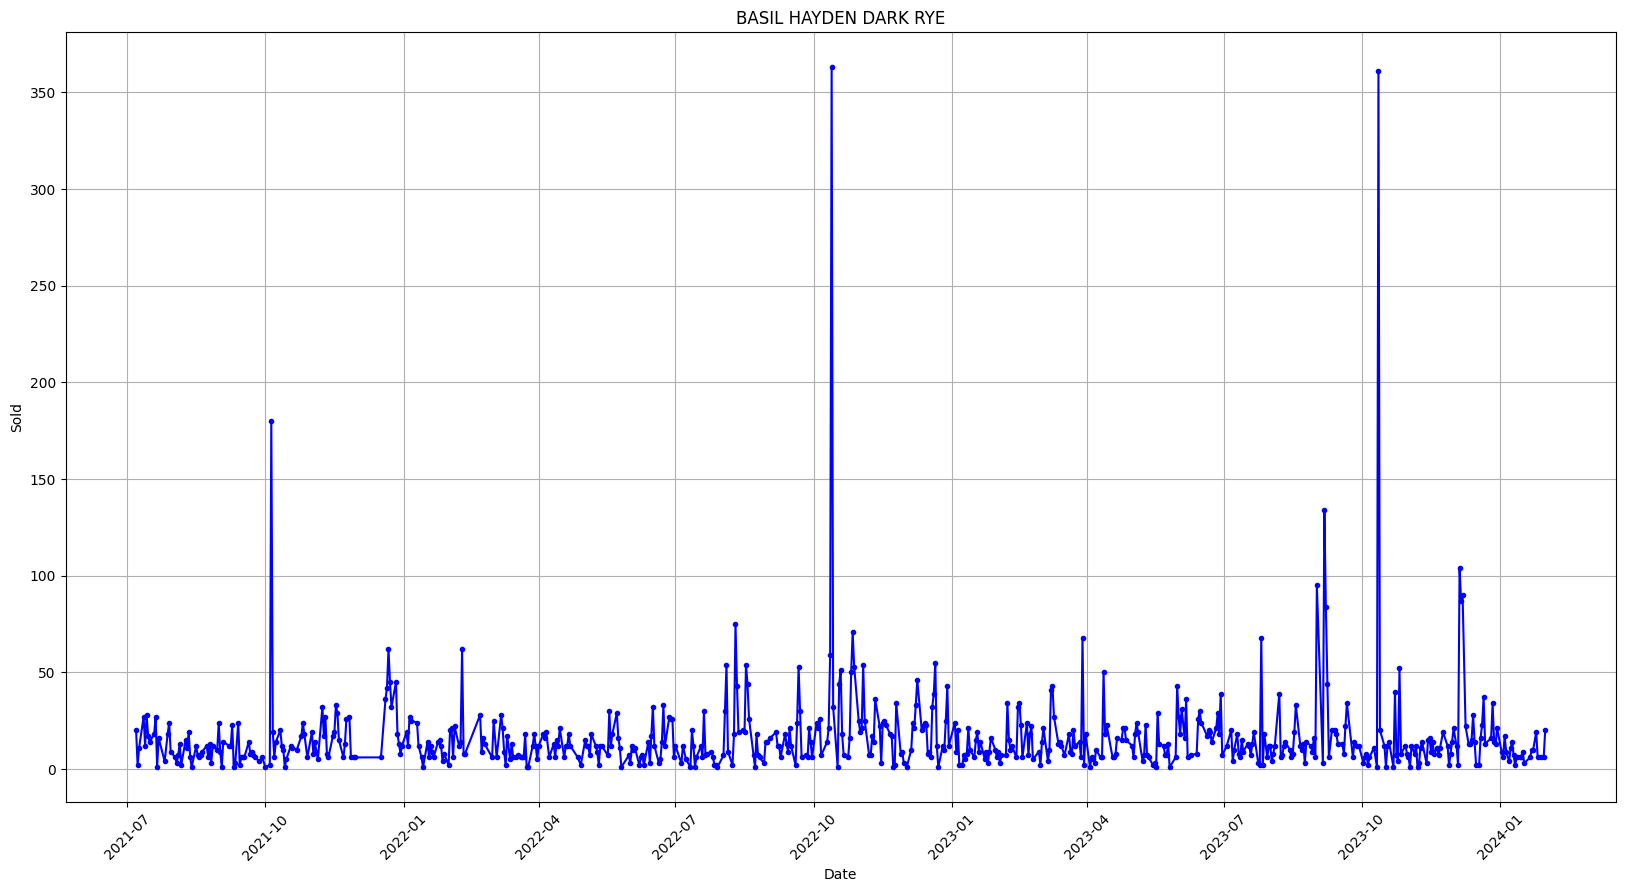

In [ ]:
# Visualise the example pattern

plt.figure(figsize=(20, 10))
plt.title("BASIL HAYDEN DARK RYE")
plt.plot(target_df_1['date'], target_df_1['total_amount_sold'], marker=".", linestyle="-", color='b')
# plt.text(.01, 55, viz_res.iloc[0].base['item_name'], ha='left', va='top', color='b')
# plt.text(.01, 53, viz_res.iloc[0].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')
# plt.text(19.2, 45, viz_res.iloc[0].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')

plt.xlabel("Date")
plt.ylabel("Sold")
# plt.title("Query Pattern")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

### Univariate Model (ARIMA_PLUS) 만들기

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `jc-gcp-project.vector_search.arima_plus_uni1`
 OPTIONS(MODEL_TYPE='ARIMA_PLUS',
         time_series_timestamp_col='ts',
         time_series_data_col='data',
         time_series_length_fraction=1
         ) AS
SELECT
CAST(date AS TIMESTAMP) ts,
total_amount_sold as data,
FROM `jc-gcp-project.vector_search.liquor_preprocessed`
where date < '2023-07-07' and date > '2021-07-06' and item_name = 'BASIL HAYDEN DARK RYE'
order by date

Query is running:   0%|          |

""


In [ ]:
%%bigquery univar_res
SELECT * FROM ML.EXPLAIN_FORECAST(MODEL `jc-gcp-project.vector_search.arima_plus_uni1`, STRUCT(30 AS horizon, 0.9 AS confidence_level));

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
univar_res

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,residual
0,2021-07-07 00:00:00+00:00,history,20.000000,20.000000,5.829652,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2.393850,NaN,NaN,0.0,0.0,17.606150
1,2021-07-08 00:00:00+00:00,history,2.000000,17.320122,5.829652,NaN,NaN,NaN,17.606139,NaN,NaN,NaN,-0.286017,NaN,NaN,0.0,0.0,-15.320122
2,2021-07-09 00:00:00+00:00,history,11.000000,2.922366,5.829652,NaN,NaN,NaN,5.739484,NaN,NaN,NaN,-2.817118,NaN,NaN,0.0,0.0,8.077634
3,2021-07-10 00:00:00+00:00,history,16.333333,18.278951,5.829652,NaN,NaN,NaN,19.744467,NaN,NaN,NaN,-1.465515,NaN,NaN,0.0,0.0,-1.945618
4,2021-07-11 00:00:00+00:00,history,21.666667,8.911180,5.829652,NaN,NaN,NaN,8.935017,NaN,NaN,NaN,-0.023837,NaN,NaN,0.0,0.0,12.755487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2023-08-01 00:00:00+00:00,forecast,16.405156,16.405156,8.953204,0.9,1.694405,31.115907,14.534539,NaN,NaN,NaN,1.870617,NaN,NaN,NaN,NaN,NaN
756,2023-08-02 00:00:00+00:00,forecast,16.882552,16.882552,8.955293,0.9,2.168369,31.596736,14.534539,NaN,NaN,NaN,2.348013,NaN,NaN,NaN,NaN,NaN
757,2023-08-03 00:00:00+00:00,forecast,22.486907,22.486907,8.957381,0.9,7.769292,37.204523,14.534539,NaN,NaN,NaN,7.952368,NaN,NaN,NaN,NaN,NaN
758,2023-08-04 00:00:00+00:00,forecast,10.480098,10.480098,8.959470,0.9,-4.240949,25.201144,14.534539,NaN,NaN,NaN,-4.054442,NaN,NaN,NaN,NaN,NaN


In [ ]:
temp_table = univar_res[univar_res['time_series_timestamp'] > '2023-06-01']

### fact랑 forecast 섞여있음

In [ ]:
hist_df = univar_res[univar_res['time_series_type'] == 'history']
fcst_df = univar_res[univar_res['time_series_type'] == 'forecast']

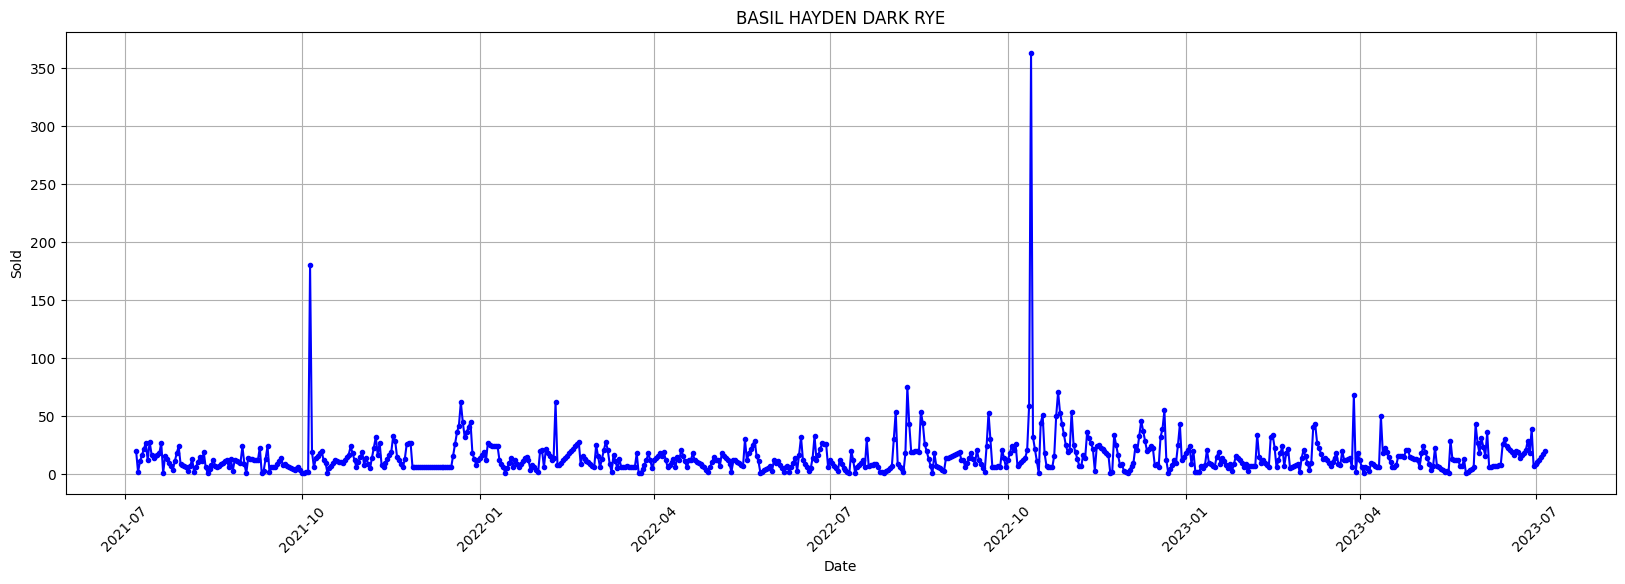

In [ ]:
# hist_df = hist_df[-160:]
plt.figure(figsize=(20, 6))
plt.title("BASIL HAYDEN DARK RYE")
plt.plot(hist_df['time_series_timestamp'], hist_df['time_series_data'], marker=".", linestyle="-", color='b')
# plt.text(.01, 55, viz_res.iloc[0].base['item_name'], ha='left', va='top', color='b')
# plt.text(.01, 53, viz_res.iloc[0].base['start_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')
# plt.text(19.2, 45, viz_res.iloc[0].base['end_time'].strftime("%Y-%m-%d"), ha='left', va='top', color='b')

plt.xlabel("Date")
plt.ylabel("Sold")
# plt.title("Query Pattern")
# plt.ylim(0, 100)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

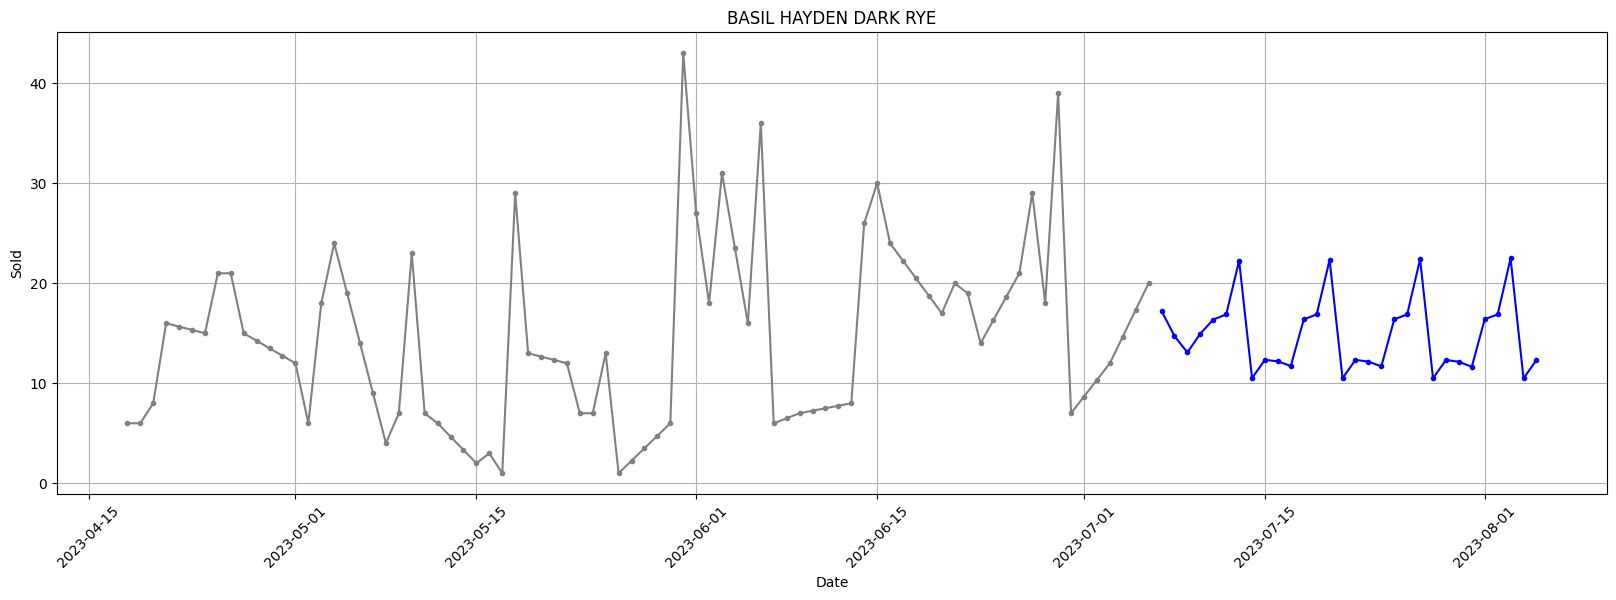

In [ ]:
hist_df = hist_df[-80:]
plt.figure(figsize=(20, 6))
plt.title("BASIL HAYDEN DARK RYE")
plt.plot(hist_df['time_series_timestamp'], hist_df['time_series_data'], marker=".", linestyle="-", color='grey')
plt.plot(fcst_df['time_series_timestamp'], fcst_df['time_series_data'], marker=".", linestyle="-", color='blue')

plt.xlabel("Date")
plt.ylabel("Sold")
# plt.title("Query Pattern")
# plt.ylim(0, 100)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [ ]:
hist_df_temp = hist_df[hist_df['time_series_timestamp']> '2023-05-15']
hist_df_temp = hist_df_temp[hist_df_temp['time_series_timestamp']< '2023-07-10']

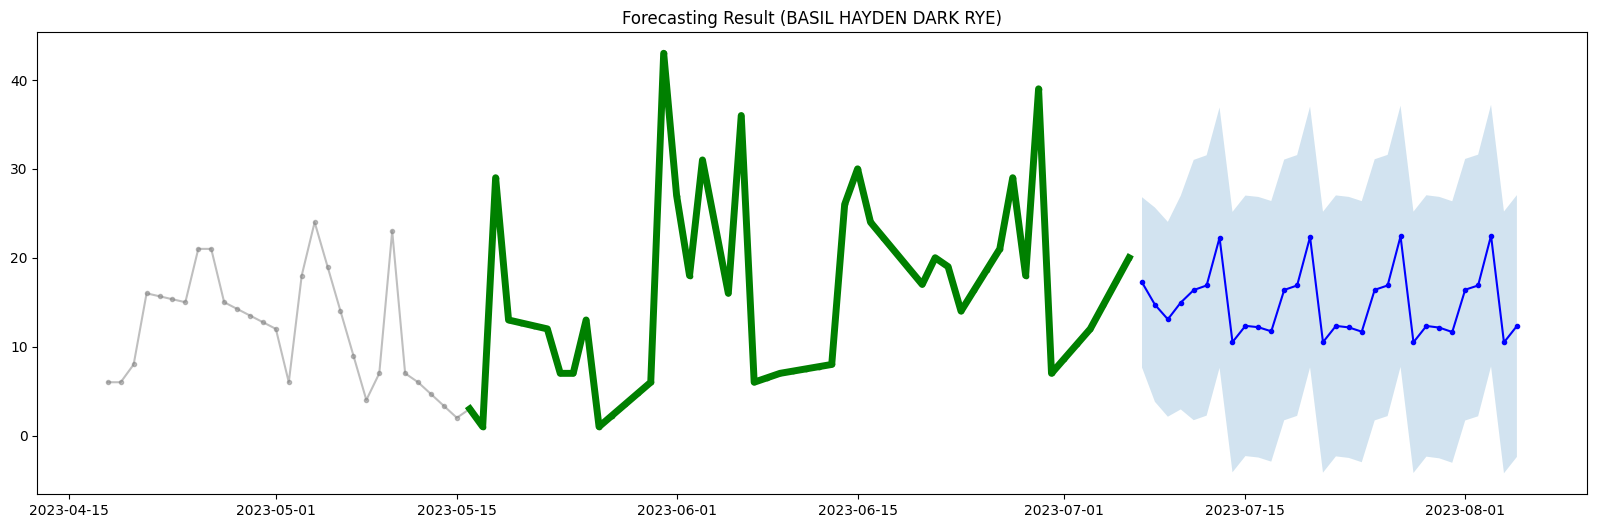

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Forecasting Result (BASIL HAYDEN DARK RYE)')
ax.plot(hist_df['time_series_timestamp'], hist_df['time_series_data'], marker=".", linestyle="-", color='grey', alpha = 0.5)
ax.plot(hist_df_temp['time_series_timestamp'], hist_df_temp['time_series_data'], marker=".", linestyle="-", color='green', alpha = 1, linewidth=5)
ax.plot(fcst_df['time_series_timestamp'], fcst_df['time_series_data'], marker=".", linestyle="-", color='blue')
ax.fill_between(fcst_df['time_series_timestamp'], fcst_df['prediction_interval_lower_bound'], fcst_df['prediction_interval_upper_bound'] , alpha=0.2)
# ax.plot(x, y, 'o', color='tab:brown')

In [ ]:
# pandas_gbq.to_gbq(embed_save, 'vector_search.embeddings', project_id='jc-gcp-project', if_exists='replace')

In [ ]:
target_df_1

,date,item_name,total_amount_sold
0,2018-11-07,BASIL HAYDEN DARK RYE,46
1,2018-11-08,BASIL HAYDEN DARK RYE,24
2,2018-11-09,BASIL HAYDEN DARK RYE,2
3,2018-11-12,BASIL HAYDEN DARK RYE,11
4,2018-11-13,BASIL HAYDEN DARK RYE,21
...,...,...,...
1000,2023-06-28,BASIL HAYDEN DARK RYE,18
1001,2023-06-29,BASIL HAYDEN DARK RYE,39
1002,2023-06-30,BASIL HAYDEN DARK RYE,7
1003,2023-07-03,BASIL HAYDEN DARK RYE,12


### Multi variate 데이터프레임 만들기

In [ ]:
#### Similarity 비슷한 Dataframe 각각 정리
for i in range(len(viz_res)):
  print(i,  "   " , viz_res.base.iloc[i]['item_name'])
  temp_df = df_preprocessed[df_preprocessed['item_name'] == viz_res.base.iloc[i]['item_name']]
  temp_df_1 = temp_df[temp_df['date'] <= viz_res.base.iloc[i]['end_time']]
  temp_df_1 = temp_df_1.sort_values('date')
  # temp_df_2 = temp_df_1[-80:]
  temp_df_2 = temp_df_1.reset_index(drop = True)
  globals()[f'res_df_{i}'] = temp_df_2

0     ABSOLUT APEACH
1     BASIL HAYDEN DARK RYE
2     BACARDI BLACK
3     ARROW PEACH SCHNAPPS
4     BACARDI TORCHED CHERRY


In [ ]:
print(len(res_df_0), len(res_df_1), len(res_df_2), len(res_df_3), len(res_df_4))

2140 1005 1605 1570 765


In [ ]:
res_df_0 = res_df_0.rename(columns={'total_amount_sold': 'ABS_sold'})
res_df_1 = res_df_1.rename(columns={'total_amount_sold': 'BASIL_sold'})
res_df_2 = res_df_2.rename(columns={'total_amount_sold': 'BACARDI_sold'})
res_df_3 = res_df_3.rename(columns={'total_amount_sold': 'ARROW_sold'})
res_df_4 = res_df_4.rename(columns={'total_amount_sold': 'TORCHED_sold'})

### df별 row count맞추기

In [ ]:
res_df_0 = res_df_0[-1005:].reset_index(drop = True)
res_df_2 = res_df_2[-1005:].reset_index(drop = True)
res_df_3 = res_df_3[-1005:].reset_index(drop = True)

In [ ]:
print(len(res_df_0), len(res_df_1), len(res_df_2), len(res_df_3), len(res_df_4))

1005 1005 1005 1005 765


### df_4는 데이터 갯수가 적어서 fake value 넣어서 맞춰주기

In [ ]:
res_df_4

,date,item_name,TORCHED_sold
0,2012-01-03,BACARDI TORCHED CHERRY,17
1,2012-01-04,BACARDI TORCHED CHERRY,34
2,2012-01-05,BACARDI TORCHED CHERRY,25
3,2012-01-09,BACARDI TORCHED CHERRY,66
4,2012-01-10,BACARDI TORCHED CHERRY,13
...,...,...,...
760,2015-08-12,BACARDI TORCHED CHERRY,41
761,2015-08-13,BACARDI TORCHED CHERRY,37
762,2015-08-17,BACARDI TORCHED CHERRY,22
763,2015-08-18,BACARDI TORCHED CHERRY,30


In [ ]:
dates = pd.date_range('2011-05-08', periods=240)

In [ ]:
dates

DatetimeIndex(['2011-05-08', '2011-05-09', '2011-05-10', '2011-05-11',
               '2011-05-12', '2011-05-13', '2011-05-14', '2011-05-15',
               '2011-05-16', '2011-05-17',
               ...
               '2011-12-24', '2011-12-25', '2011-12-26', '2011-12-27',
               '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31',
               '2012-01-01', '2012-01-02'],
              dtype='datetime64[ns]', length=240, freq='D')

In [ ]:
# 샘플 데이터 생성
dates = pd.date_range('2011-05-08 00:00:00', periods=240)
item_name = "BACARDI TORCHED CHERRY"
TORCHED_sold = round(np.mean(res_df_4['TORCHED_sold']))

adding_df = pd.DataFrame({'date': dates, 'item_name': item_name, 'TORCHED_sold':TORCHED_sold})

In [ ]:
adding_df['date']

,date,item_name,TORCHED_sold
0,2011-05-08,BACARDI TORCHED CHERRY,31
1,2011-05-09,BACARDI TORCHED CHERRY,31
2,2011-05-10,BACARDI TORCHED CHERRY,31
3,2011-05-11,BACARDI TORCHED CHERRY,31
4,2011-05-12,BACARDI TORCHED CHERRY,31
...,...,...,...
235,2011-12-29,BACARDI TORCHED CHERRY,31
236,2011-12-30,BACARDI TORCHED CHERRY,31
237,2011-12-31,BACARDI TORCHED CHERRY,31
238,2012-01-01,BACARDI TORCHED CHERRY,31


In [ ]:
# Fake Table과 합치기
con = pd.concat([adding_df, res_df_4], axis=0, ignore_index=True)
# Date 포맷 맞춰주기
con['date'] = pd.to_datetime(con['date'])

In [ ]:
res_df_4 = copy.copy(con)

In [ ]:
res_df_4

,date,item_name,TORCHED_sold
0,2011-05-08,BACARDI TORCHED CHERRY,31
1,2011-05-09,BACARDI TORCHED CHERRY,31
2,2011-05-10,BACARDI TORCHED CHERRY,31
3,2011-05-11,BACARDI TORCHED CHERRY,31
4,2011-05-12,BACARDI TORCHED CHERRY,31
...,...,...,...
1000,2015-08-12,BACARDI TORCHED CHERRY,41
1001,2015-08-13,BACARDI TORCHED CHERRY,37
1002,2015-08-17,BACARDI TORCHED CHERRY,22
1003,2015-08-18,BACARDI TORCHED CHERRY,30


### Multivariate을 위한 DataFrame 합치기 (Date 무시)

In [ ]:
# df 길이 맞춰서 DF concat 진행
print(len(res_df_0), len(res_df_1), len(res_df_2), len(res_df_3), len(res_df_4))

1005 1005 1005 1005 1005


### DataFrame 합치기

In [ ]:
#### res_df_1이 기준이고 다른 테이블의 sold값을 붙인다
extracted_col = res_df_0["ABS_sold"]

# Add the extracted column to the second DataFrame
multi_df = pd.concat([res_df_1, extracted_col], axis=1)

In [ ]:
# res_df_2 합치기
extracted_col = res_df_2["BACARDI_sold"]
multi_df = pd.concat([multi_df, extracted_col], axis=1)
# res_df_3 합치기
extracted_col = res_df_3["ARROW_sold"]
multi_df = pd.concat([multi_df, extracted_col], axis=1)
# res_df_4 합치기
extracted_col = res_df_4["TORCHED_sold"]
multi_df = pd.concat([multi_df, extracted_col], axis=1)

In [ ]:
multi_df

,date,item_name,BASIL_sold,ABS_sold,BACARDI_sold,ARROW_sold,TORCHED_sold
0,2018-11-07,BASIL HAYDEN DARK RYE,46,13,6,54,31
1,2018-11-08,BASIL HAYDEN DARK RYE,24,29,12,2,31
2,2018-11-09,BASIL HAYDEN DARK RYE,2,16,24,6,31
3,2018-11-12,BASIL HAYDEN DARK RYE,11,18,2,66,31
4,2018-11-13,BASIL HAYDEN DARK RYE,21,5,8,63,31
...,...,...,...,...,...,...,...
1000,2023-06-28,BASIL HAYDEN DARK RYE,18,40,18,27,41
1001,2023-06-29,BASIL HAYDEN DARK RYE,39,67,42,47,37
1002,2023-06-30,BASIL HAYDEN DARK RYE,7,26,12,19,22
1003,2023-07-03,BASIL HAYDEN DARK RYE,12,6,16,36,30


### multi Table을 빅쿼리 데이블로 저장

In [ ]:
pandas_gbq.to_gbq(multi_df, 'vector_search.xreg_df', project_id='jc-gcp-project', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 3587.94it/s]


In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `jc-gcp-project.vector_search.arima_plus_xreg`
 OPTIONS(MODEL_TYPE='ARIMA_PLUS_XREG',
         time_series_timestamp_col='ts',
         time_series_data_col='data',
         time_series_length_fraction=1
         ) AS
SELECT
PARSE_TIMESTAMP("%Y-%m-%d", SUBSTRING(date, 1, 10)) AS ts,
BASIL_sold as data,
ABS_sold,
BACARDI_sold,
ARROW_sold,
TORCHED_sold
FROM `jc-gcp-project.vector_search.xreg_df`

Query is running:   0%|          |

""


In [ ]:
%%bigquery multi_res
SELECT
  *
FROM
  ML.EXPLAIN_FORECAST(MODEL `jc-gcp-project.vector_search.arima_plus_xreg`,
    STRUCT(30 AS horizon, 0.8 AS confidence_level),
    (SELECT
        PARSE_TIMESTAMP("%Y-%m-%d", SUBSTRING(date, 1, 10)) AS ts,
        BASIL_sold as data,
        ABS_sold,
        BACARDI_sold,
        ARROW_sold,
        TORCHED_sold
    FROM `jc-gcp-project.vector_search.xreg_df`))

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
multi_res

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,...,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,residual,attribution_ABS_sold,attribution_BACARDI_sold,attribution_ARROW_sold,attribution_TORCHED_sold,attribution___INTERCEPT__
0,2018-11-07 00:00:00+00:00,history,46.000000,50.278032,5.567966,NaN,NaN,NaN,10.200376,NaN,...,NaN,NaN,0.0,-4.278032,25.711684,0.365219,-0.005563,-0.286320,0.708629,1.452416
1,2018-11-08 00:00:00+00:00,history,24.000000,33.996082,5.567966,NaN,NaN,NaN,27.738609,NaN,...,NaN,NaN,0.0,-4.278032,-5.718051,0.814719,-0.011127,-0.010604,0.708629,1.452416
2,2018-11-09 00:00:00+00:00,history,2.000000,14.966329,5.567966,NaN,NaN,NaN,18.557459,NaN,...,NaN,NaN,0.0,-4.278032,-8.688297,0.449500,-0.022253,-0.031813,0.708629,1.452416
3,2018-11-10 00:00:00+00:00,history,NaN,NaN,5.567966,NaN,NaN,NaN,16.588570,NaN,...,NaN,NaN,0.0,-4.278032,-4.601497,NaN,NaN,NaN,NaN,NaN
4,2018-11-11 00:00:00+00:00,history,NaN,NaN,5.567966,NaN,NaN,NaN,14.324560,NaN,...,NaN,NaN,0.0,-4.278032,-0.216884,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2023-08-01 00:00:00+00:00,forecast,15.026339,15.026339,9.126501,0.8,3.323550,26.729129,10.200376,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1729,2023-08-02 00:00:00+00:00,forecast,14.852295,14.852295,9.126501,0.8,3.149506,26.555085,10.200376,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1730,2023-08-03 00:00:00+00:00,forecast,20.332089,20.332089,9.126501,0.8,8.629299,32.034878,10.200376,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1731,2023-08-04 00:00:00+00:00,forecast,9.023270,9.023270,9.126501,0.8,-2.679519,20.726060,10.200376,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416


### 평가 비교

### Fact 추출

In [ ]:
base_comp = target_df[target_df['date'] >= datetime.date(2023, 7, 7)]

In [ ]:
base_comp = base_comp[:30]

In [ ]:
base_comp.head()

,date,item_name,total_amount_sold
1005,2023-07-07,BASIL HAYDEN DARK RYE,4
1006,2023-07-08,BASIL HAYDEN DARK RYE,10
1007,2023-07-10,BASIL HAYDEN DARK RYE,18
1008,2023-07-11,BASIL HAYDEN DARK RYE,8
1009,2023-07-12,BASIL HAYDEN DARK RYE,6


In [ ]:
univar_comp = univar_res[univar_res['time_series_type'] == 'forecast']

In [ ]:
multi_comp = multi_res[multi_res['time_series_type'] == 'forecast']

In [ ]:
multi_comp.head()

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,...,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,residual,attribution_ABS_sold,attribution_BACARDI_sold,attribution_ARROW_sold,attribution_TORCHED_sold,attribution___INTERCEPT__
1703,2023-07-07 00:00:00+00:00,forecast,11.077936,11.077936,5.567966,0.8,3.938207,18.217664,12.289382,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1704,2023-07-08 00:00:00+00:00,forecast,15.528773,15.528773,6.459060,0.8,7.246407,23.811140,14.494457,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1705,2023-07-09 00:00:00+00:00,forecast,12.384157,12.384157,6.627407,0.8,3.885921,20.882393,11.873942,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1706,2023-07-10 00:00:00+00:00,forecast,10.312237,10.312237,7.449875,0.8,0.759362,19.865112,9.892529,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1707,2023-07-11 00:00:00+00:00,forecast,14.902807,14.902807,8.801130,0.8,3.617235,26.188379,10.059342,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416


In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true = base_comp.total_amount_sold.values, y_pred = multi_comp['time_series_data'])
MSE

191.34663204487296

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true = base_comp.total_amount_sold.values, y_pred = univar_comp['time_series_data'])

9.114266993852802

In [ ]:
mean_absolute_error(y_true = base_comp.total_amount_sold.values, y_pred = multi_comp['time_series_data'])

8.211806484619235

In [ ]:
multi_comp

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,...,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,residual,attribution_ABS_sold,attribution_BACARDI_sold,attribution_ARROW_sold,attribution_TORCHED_sold,attribution___INTERCEPT__
1703,2023-07-07 00:00:00+00:00,forecast,11.077936,11.077936,5.567966,0.8,3.938207,18.217664,12.289382,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1704,2023-07-08 00:00:00+00:00,forecast,15.528773,15.528773,6.459060,0.8,7.246407,23.811140,14.494457,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1705,2023-07-09 00:00:00+00:00,forecast,12.384157,12.384157,6.627407,0.8,3.885921,20.882393,11.873942,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1706,2023-07-10 00:00:00+00:00,forecast,10.312237,10.312237,7.449875,0.8,0.759362,19.865112,9.892529,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1707,2023-07-11 00:00:00+00:00,forecast,14.902807,14.902807,8.801130,0.8,3.617235,26.188379,10.059342,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1708,2023-07-12 00:00:00+00:00,forecast,14.913142,14.913142,9.059180,0.8,3.296676,26.529608,10.135764,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1709,2023-07-13 00:00:00+00:00,forecast,20.254115,20.254115,9.112412,0.8,8.569390,31.938840,10.170775,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1710,2023-07-14 00:00:00+00:00,forecast,8.983954,8.983954,9.123546,0.8,-2.715047,20.682954,10.186815,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1711,2023-07-15 00:00:00+00:00,forecast,11.242340,11.242340,9.125880,0.8,-0.459654,22.944335,10.194163,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416
1712,2023-07-16 00:00:00+00:00,forecast,10.715507,10.715507,9.126370,0.8,-0.987115,22.418130,10.197529,NaN,...,NaN,NaN,NaN,NaN,NaN,0.901852,-0.017214,-0.204977,0.716522,1.452416


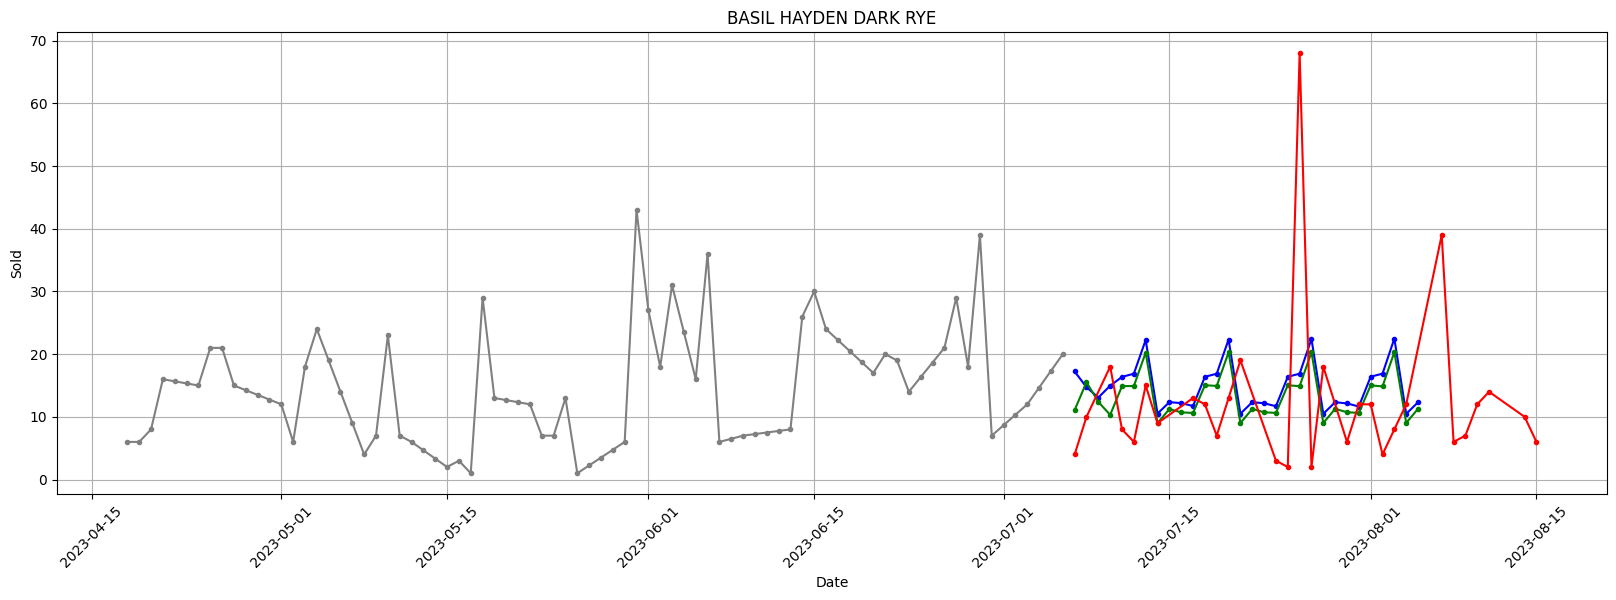

In [ ]:
hist_df = hist_df[-80:]
plt.figure(figsize=(20, 6))
plt.title("BASIL HAYDEN DARK RYE")
plt.plot(hist_df['time_series_timestamp'], hist_df['time_series_data'], marker=".", linestyle="-", color='grey')
plt.plot(fcst_df['time_series_timestamp'], fcst_df['time_series_data'], marker=".", linestyle="-", color='blue')
plt.plot(multi_comp['time_series_timestamp'], multi_comp['time_series_data'], marker=".", linestyle="-", color='green')
plt.plot(base_comp['date'], base_comp['total_amount_sold'], marker=".", linestyle="-", color='red')

plt.xlabel("Date")
plt.ylabel("Sold")
# plt.title("Query Pattern")
# plt.ylim(0, 100)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()